In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw,ImageOps 
import math
import random
import json
import csv
import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [3]:
# part 1
images_path = './uav-bd/test/images/'
labels_path = './uav-bd/test/labels/'

images_png = glob.glob(images_path + '*')
ds_size = len(images_png)

print("Number of images in the part:", len(images_png))

Number of images in the part: 5079


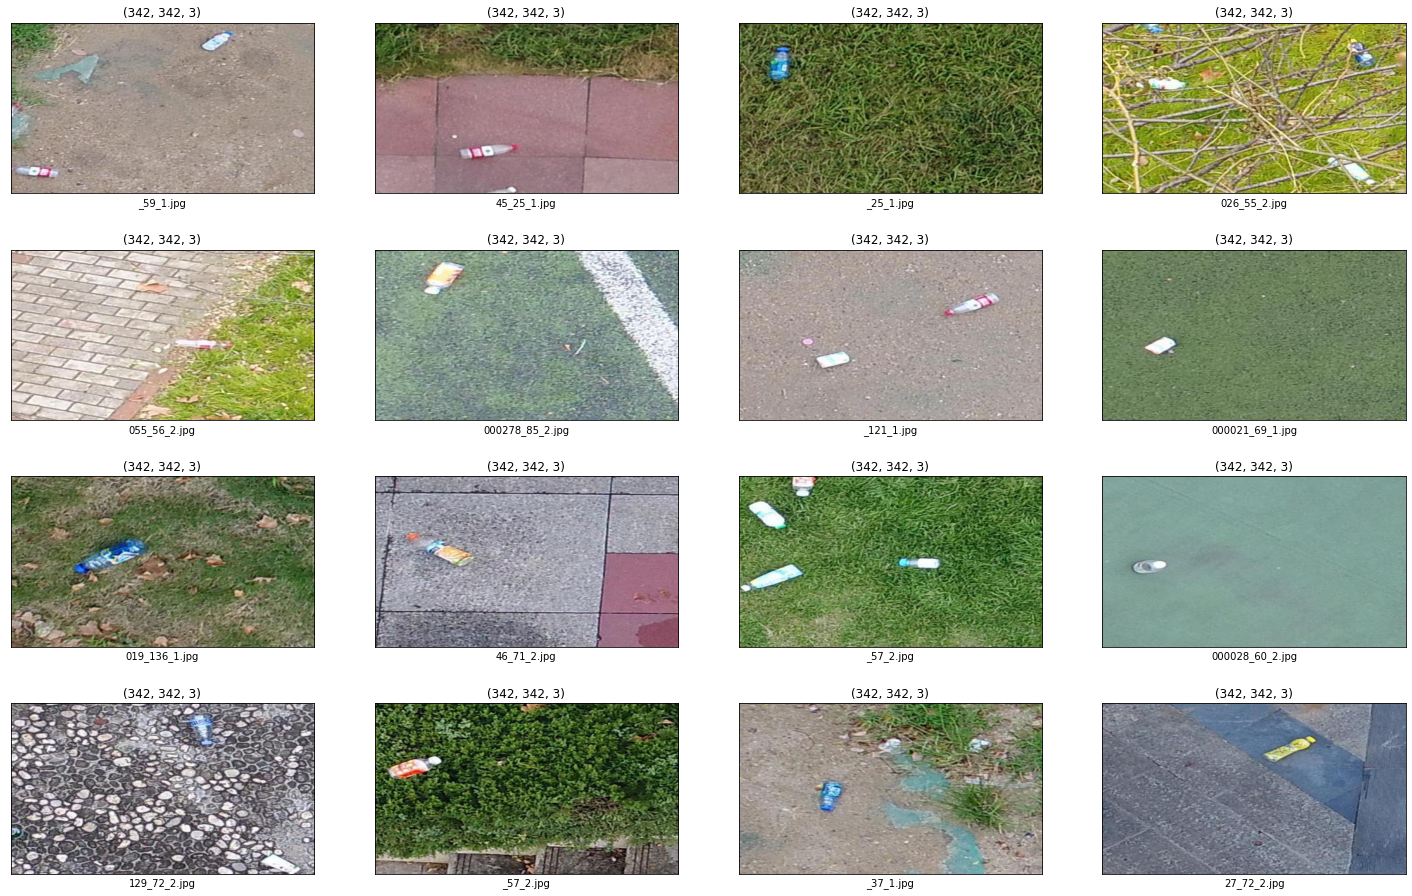

In [3]:
# Draw some random examples
np.random.seed(1)
images_to_draw = [images_png[i] for i in np.random.randint(0, ds_size, 16)]

fig = plt.figure(figsize=(25, 16))
for i,im_path in enumerate(images_to_draw):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(im_path)
    plt.title(np.shape(im))
    plt.xlabel(im_path[34:])
    im = im.resize((480,270))
    plt.imshow(im)


## Image details

In [4]:
# check if all pictures have the same size

# get all sizes
sizes = np.array([Image.open(path).size for path in images_png])

# check the distribution
unicos = [np.unique(sizes)]
print('There are {0} unique sizes'.format(len(unicos)))

print(unicos)

There are 1 unique sizes
[array([342])]


## Histograms

In [ ]:
for i,im_path in enumerate(images_png[:8]):
    im1 = Image.open(im_path)
    im2 = ImageOps.equalize(im1, mask = None)

    hst1=im1.histogram()
    hst2=im2.histogram()
    
    #limitar a las frecuencias superiores a 50000 para una mejor visiualizacion del histograma
    for j in range(0, 768):     
        if hst1[j]>=50000 : hst1[j] = 50000 #limitar a las frecuencias superiores a 50000 para una mejor visiualizacion del histograma
        if hst2[j]>=50000 : hst2[j] = 50000 #limitar a las frecuencias superiores a 50000 para una mejor visiualizacion del histograma
    
    plt.figure(figsize=(30, 3))
    
    plt.subplot(141)
    im1 = im1.resize((480,270))
    plt.title('Imagen original')
    plt.imshow(im1)
    
    plt.subplot(142)
    im2 = im2.resize((480,270))
    plt.title('Imagen ecualizada')
    plt.imshow(im2)
        
    plt.subplot(143)
    for i in range(0, 256):
        plt.bar(i, hst1[i],color = 'red'   ,alpha=0.3)
        plt.bar(i, hst1[i+256], color = 'green',alpha=0.3)
        plt.bar(i, hst1[i+512], color = 'blue',alpha=0.3)
        plt.title('Histograma imagen original')
    plt.figure(1)             # plots a figure to display Histogram
        
    plt.subplot(144)
    for i in range(0, 256):
        plt.bar(i, hst2[i],color = 'red'   ,alpha=0.3)
        plt.bar(i, hst2[i+256], color = 'green',alpha=0.3)
        plt.bar(i, hst2[i+512], color = 'blue',alpha=0.3)
        plt.title('Histogram imagen ecualizada')
    plt.figure(1)             # plots a figure to display Histogram


    plt.show()

## Get label details

### json2csv

In [4]:
with open ('./uav-bd/coco/annotations/uavbd_test_.json','r') as f:
    data = json.load(f)
    annotations = data['annotations']
    images = data['images']


with open('./uav-bd/coco/annotations/uavbd_test_.csv','w') as f:
    fieldnames = annotations[0].keys()
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for name in annotations:
        writer.writerow(name)

with open('./uav-bd/coco/annotations/uavbd_imtest_.csv','w') as f:
    fieldnames = images[0].keys()
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for name in images:
        writer.writerow(name)


### labels

In [5]:
test_labels = glob.glob('./uav-bd/coco/annotations/uavbd_test_.csv')
frames = []

data_img = pd.read_csv('./uav-bd/coco/annotations/uavbd_test_.csv')
csv_test_img = pd.read_csv('./uav-bd/coco/annotations/uavbd_imtest_.csv')


print(data_img.info())
print(csv_test_img.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7504 entries, 0 to 7503
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          7504 non-null   float64
 1   bbox          7504 non-null   object 
 2   category_id   7504 non-null   int64  
 3   id            7504 non-null   int64  
 4   image_id      7504 non-null   int64  
 5   iscrowd       7504 non-null   int64  
 6   segmentation  7504 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 410.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5079 entries, 0 to 5078
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date_captured  5079 non-null   int64 
 1   file_name      5079 non-null   object
 2   height         5079 non-null   int64 
 3   id             5079 non-null   int64 
 4   license        5079 non-null   int64 
 5   url            5079 non-nu

### Select image

In [14]:
ran = random.randint(0, ds_size) 
image_path = images_png[ran] #random image
img_file = os.path.basename(image_path) #get the  basename

row = csv_test_img[csv_test_img['file_name'] == img_file] #dataframe with selected image
img_name = row['file_name'].item()
img_id = row['id'].item()

data_id = data_img[data_img['image_id'] == img_id] # info from the other DF
boxes = data_id.segmentation.values


#selecting the string and convert it to int
list1 = [re.findall(r'\d{1,3}\.\d{2,15}', strn) for strn in boxes]
box_list = [[int(float(b)) for b in a] for a in list1]


## Drawing


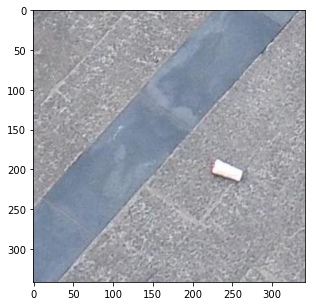

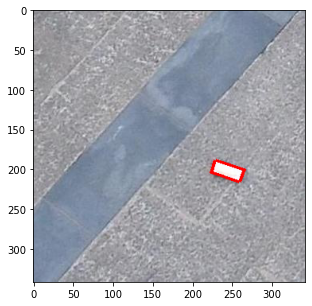

In [15]:
# creating new Image object
img = Image.open(image_path)
fig = plt.figure(figsize=(5, 5))
plt.imshow(img)

img1 = ImageDraw.Draw(img)  
for coor in box_list:
    shape = [(coor[0], coor[1]), (coor[2], coor[3]), (coor[4], coor[5]), (coor[6], coor[7]),(coor[0], coor[1])]
    # create line image
    img1.line(shape, fill = 'red', width = 4)

fig = plt.figure(figsize=(5, 5))
plt.imshow(img)

